In [9]:
import sys
sys.path.append("../") 

In [10]:
from __future__ import division

import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.,1.)
])

In [12]:
num_gpus = 0
model_ctx = mx.gpu()

num_workers = 0
batch_size = 512 
train_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=True).transform_first(transform),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=False).transform_first(transform),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [13]:
for X,y in train_data:
    print(X.shape)
    print(y.shape)
    break

(512, 1, 28, 28)
(512,)


In [14]:
model_ctx

gpu(0)

In [15]:
type(X)

mxnet.numpy.ndarray

### Bayesian inference for MNIST

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)
* [Bayes By Backprop](#chapter3)
* [Diagnostics](#chapter4)


# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

In [16]:
import mxnet as mx
from mxnet import nd, autograd, gluon
hyper={'alpha':10.}
in_units=(1,28,28)
out_units=10

In [39]:
import mxnet as mx
from hamiltonian.inference.distilled_sgd import distilled_sgd
from hamiltonian.models.softmax import lenet
import h5py 

teacher=lenet(hyper,in_units,out_units,ctx=model_ctx)
map_estimate=h5py.File('lenet_map.h5','r')
par={var:map_estimate[var][:] for var in map_estimate.keys()}
map_estimate.close()
teacher.net.load_dict(par,ctx=mx.gpu())

student=lenet(hyper,in_units,out_units,ctx=model_ctx)

inference=distilled_sgd(teacher,student,alpha=0.9,temperature=0.9,step_size=0.01,ctx=model_ctx)

In [38]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.distilled_sgd)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


modules re-loaded


iteration 0, train loss: 116022.7692, train accuracy : 0.0997
iteration 1, train loss: 115604.1624, train accuracy : 0.2634
iteration 2, train loss: 115190.7692, train accuracy : 0.4677
iteration 3, train loss: 115096.7607, train accuracy : 0.5871
iteration 4, train loss: 115069.1368, train accuracy : 0.6626
iteration 5, train loss: 115054.4615, train accuracy : 0.7141
iteration 6, train loss: 115046.6325, train accuracy : 0.7521
iteration 7, train loss: 115041.6581, train accuracy : 0.7807
iteration 8, train loss: 115037.5214, train accuracy : 0.8034
iteration 9, train loss: 115034.4957, train accuracy : 0.8218


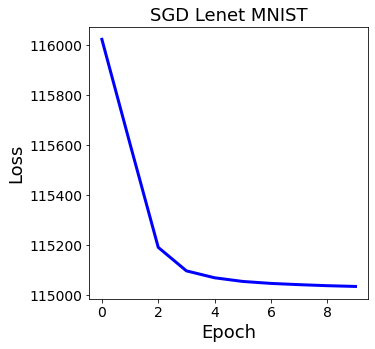

In [40]:
train_sgd=True
num_epochs=10
import h5py
import matplotlib.pyplot as plt

if train_sgd:
    par,loss=inference.fit(epochs=num_epochs,batch_size=batch_size,data_loader=train_data,
                           chain_name='lenet_map_distilled.h5',verbose=True)

    fig=plt.figure(figsize=[5,5])
    plt.plot(loss,color='blue',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGD Lenet MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgd_lenet.pdf', bbox_inches='tight')
else:
    map_estimate=h5py.File('lenet_map_distilled.h5','r')
    par={var:map_estimate[var][:] for var in map_estimate.keys()}
    map_estimate.close()
    

In [41]:
map_estimate=h5py.File('lenet_map_distilled.h5','r')
par={var:map_estimate[var][:] for var in map_estimate.keys()}
map_estimate.close()

In [42]:
total_samples,total_labels,log_like=inference.predict(par,batch_size=batch_size,num_samples=100,data_loader=val_data)

In [43]:
y_hat=np.quantile(total_samples,.5,axis=0)

In [44]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.97      0.98      0.97      1010
           4       1.00      0.96      0.98       982
           5       0.93      0.99      0.96       892
           6       0.95      0.99      0.97       958
           7       0.99      0.95      0.97      1028
           8       0.89      0.99      0.94       974
           9       0.99      0.91      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



# Stochastic Gradient Langevin Dynamics <a class="anchor" id="chapter2"></a>

In [45]:
from hamiltonian.inference.distilled_sgld import distilled_sgld
from hamiltonian.models.softmax import lenet

teacher=lenet(hyper,in_units,out_units,ctx=model_ctx)
map_estimate=h5py.File('lenet_map.h5','r')
par={var:map_estimate[var][:] for var in map_estimate.keys()}
map_estimate.close()
teacher.net.load_dict(par,ctx=mx.gpu())

student=lenet(hyper,in_units,out_units,ctx=model_ctx)
inference=distilled_sgld(teacher,student,alpha=0.9,temperature=0.9,step_size=0.01,ctx=model_ctx)

In [46]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.distilled_sgld)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

modules re-loaded


In [47]:
train_sgld=True
num_epochs=10

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='lenet_posterior_distilled.h5')


AttributeError: 'distilled_sgd' object has no attribute 'sample'

In [23]:
import h5py 

posterior_samples=h5py.File('lenet_posterior.h5','r')

In [24]:
total_samples,total_labels,log_like=inference.predict(posterior_samples,data_loader=val_data)

In [25]:
from sklearn.metrics import classification_report
posterior_samples

y_hat=np.quantile(total_samples,.5,axis=0)

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [35]:
import tensorflow as tf
import tensorflow_probability as tfp

samples={var:posterior_samples[var] for var in posterior_samples.keys()}
samples={var:np.swapaxes(samples[var],0,1) for var in posterior_samples.keys()}
r_hat_estimate = lambda samples : tfp.mcmc.diagnostic.potential_scale_reduction(samples, independent_chain_ndims=1,split_chains=False).numpy()
rhat = {var:r_hat_estimate(samples[var]) for var in posterior_samples.keys()}
median_rhat_flat={var:np.median(rhat[var]) for var in rhat}

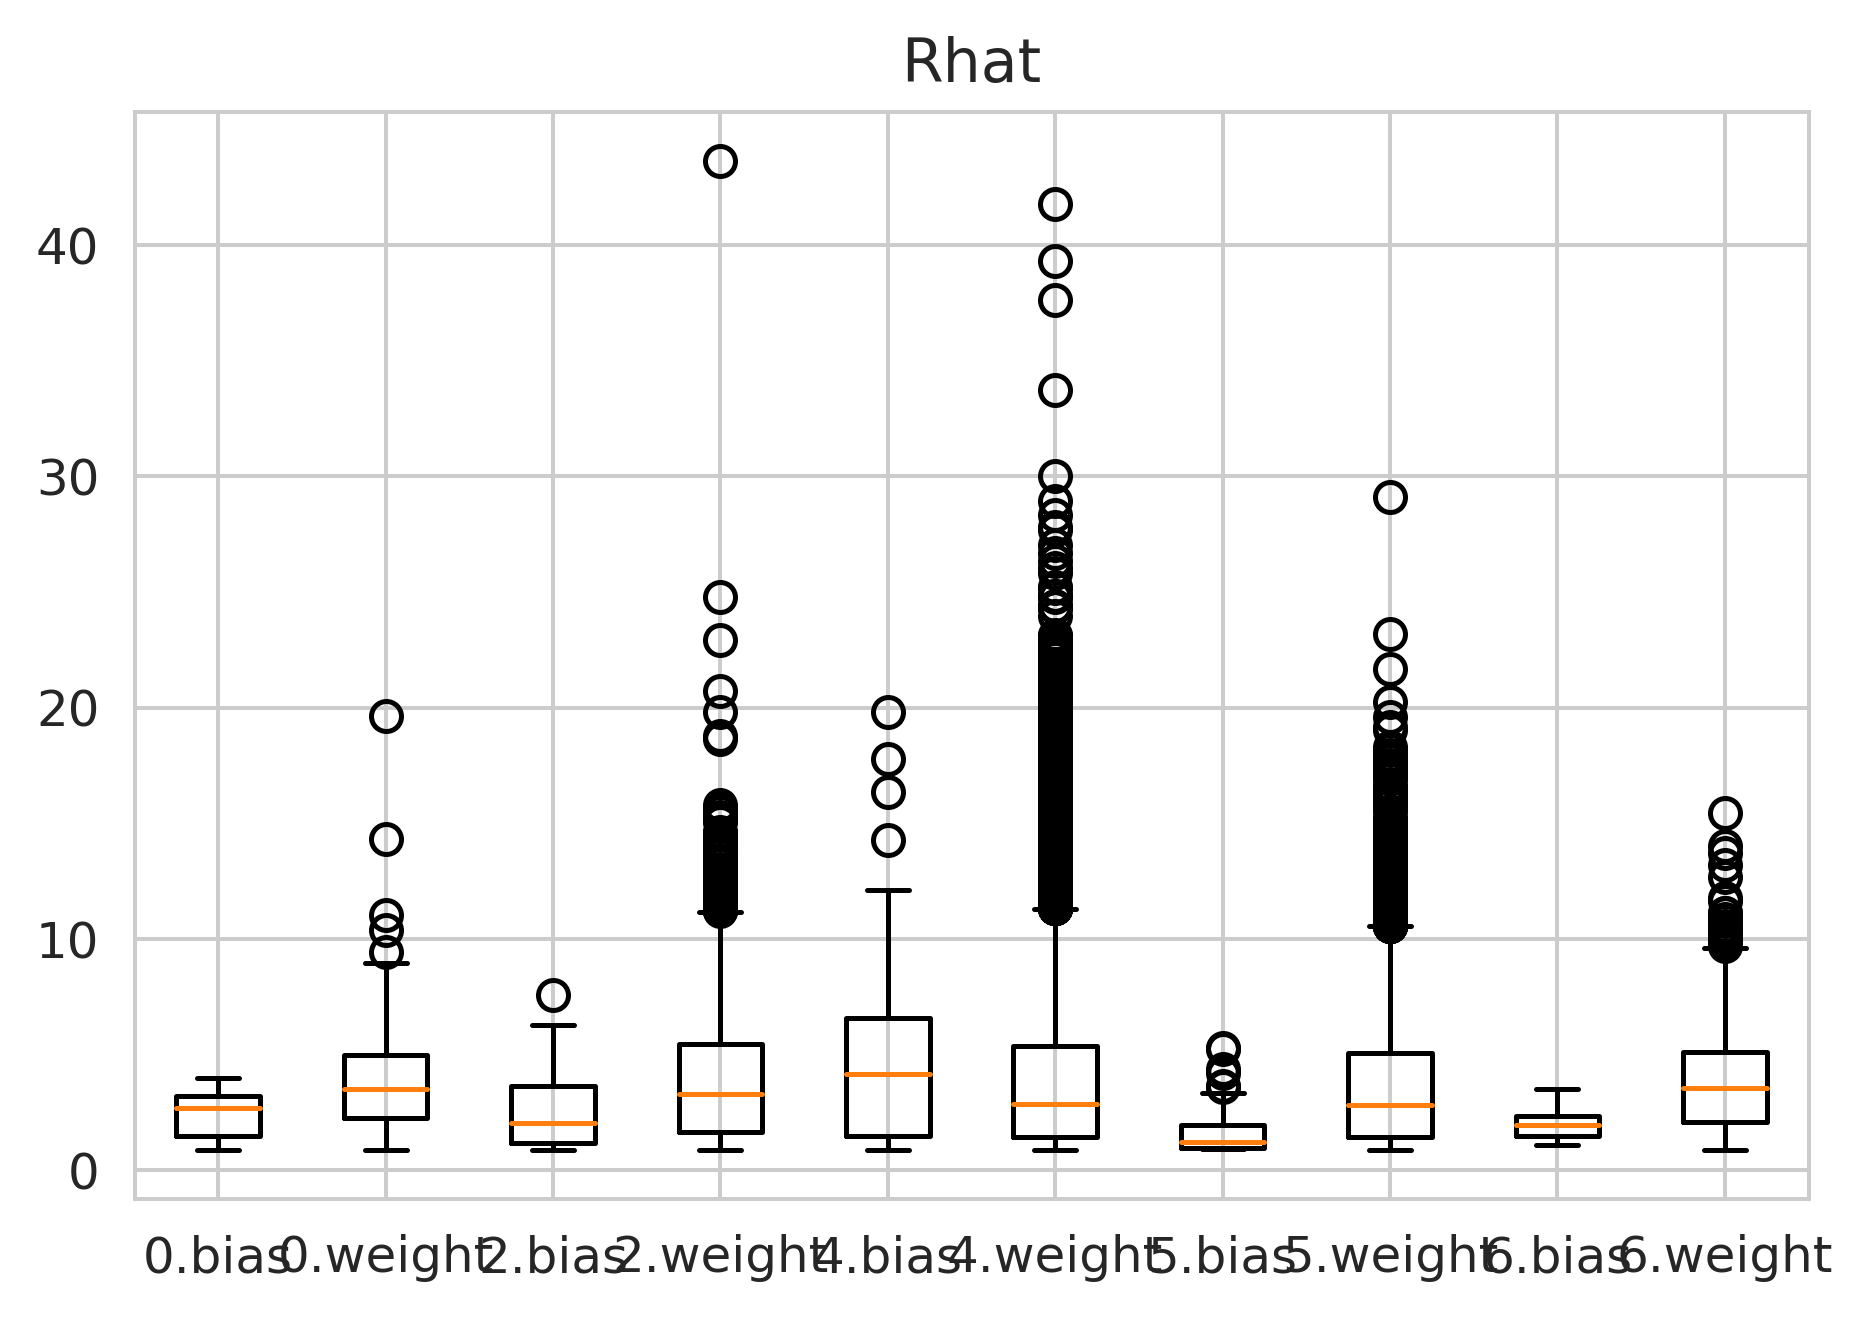

In [37]:
import seaborn as sns

labels, data = rhat.keys(), rhat.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))

plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('Rhat')
plt.savefig('rhat_nonhierarchical_lenet.pdf', bbox_inches='tight')

In [ ]:
ess_estimate = lambda samples : tfp.mcmc.diagnostic.effective_sample_size(samples, filter_beyond_positive_pairs=False,cross_chain_dims=1).numpy()
ess = {var:ess_estimate(samples[var]) for var in model.par}
median_ess_flat={var:np.median(ess[var]) for var in ess}

In [ ]:
labels, data = ess.keys(), ess.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))
plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")    
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('ESS')
plt.savefig('ess_nonhierarchical_lenet.pdf', bbox_inches='tight')

In [ ]:
from hamiltonian.utils.psis import *

loo,loos,ks=psisloo(log_like)
max_ks=max(ks[~ np.isinf(ks)])

In [ ]:
flat_ks_1=np.sum(ks>1)
flat_ks_7_1=np.sum(np.logical_and(ks>0.7,ks<1))
flat_ks_5_7=np.sum(np.logical_and(ks>0.5,ks<0.7))
flat_ks_5=np.sum(ks<0.5)

# Hierarchical Lenet <a class="anchor" id="chapter3"></a>

In [ ]:
from hamiltonian.inference.sgld import hierarchical_sgld
from hamiltonian.models.softmax import hierarchical_lenet

model=hierarchical_lenet(hyper,in_units,out_units,ctx=model_ctx)
inference=hierarchical_sgld(model,par,step_size=0.001,ctx=model_ctx)

In [ ]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgld)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import glob

train_sgld=True
num_epochs=250

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='hierarchical_lenet_posterior.h5')

    plt.rcParams['figure.dpi'] = 360
    sns.set_style("whitegrid")
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss[0],color='blue',lw=3)
    plt.plot(loss[1],color='red',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGLD Hierarchical Lenet MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgld_hierarchical_lenet.pdf', bbox_inches='tight')


In [ ]:
import h5py 

posterior_samples=h5py.File('hierarchical_lenet_posterior.h5','r')

In [ ]:
total_samples,total_labels,log_like=inference.predict(posterior_samples,data_loader=val_data)

In [ ]:
from sklearn.metrics import classification_report


y_hat=np.quantile(total_samples,.5,axis=0)

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

samples={var:posterior_samples[var] for var in posterior_samples.keys()}
samples={var:np.swapaxes(samples[var],0,1) for var in model.par}
r_hat_estimate = lambda samples : tfp.mcmc.diagnostic.potential_scale_reduction(samples, independent_chain_ndims=1,split_chains=True).numpy()
rhat = {var:r_hat_estimate(samples[var]) for var in model.par}
median_rhat_hierarchical={var:np.median(rhat[var]) for var in rhat}

In [ ]:
labels, data = rhat.keys(), rhat.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))

plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('Rhat')
plt.savefig('rhat_hierarchical_lenet.pdf', bbox_inches='tight')

In [ ]:
ess_estimate = lambda samples : tfp.mcmc.diagnostic.effective_sample_size(samples, filter_beyond_positive_pairs=False,cross_chain_dims=1).numpy()
ess = {var:ess_estimate(samples[var]) for var in model.par}
median_ess_hierarchical={var:np.median(ess[var]) for var in ess}

In [ ]:
labels, data = ess.keys(), ess.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))
plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")    
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('ESS')
plt.savefig('ess_hierarchical_lenet.pdf', bbox_inches='tight')

In [ ]:
from hamiltonian.utils.psis import *

loo,loos,ks=psisloo(log_like)
max_ks=max(ks[~ np.isinf(ks)])

In [ ]:
hierarchical_ks_1=np.sum(ks>1)
hierarchical_ks_7_1=np.sum(np.logical_and(ks>0.7,ks<1))
hierarchical_ks_5_7=np.sum(np.logical_and(ks>0.5,ks<0.7))
hierarchical_ks_5=np.sum(ks<0.5)

In [ ]:
import pandas as pd

hierarchical=[hierarchical_ks_1,hierarchical_ks_7_1,hierarchical_ks_5_7,hierarchical_ks_5]
flat=[flat_ks_1,flat_ks_7_1,flat_ks_5_7,flat_ks_5]
index = ['k>1', '0.7<k<1', '0.5<k<0.7','k<0.5']
df = pd.DataFrame({'hierarchical': hierarchical,
                   'non-hierarchical': flat}, index=index)
ax = df.plot.bar(rot=0)
plt.title('Pareto K shape')

In [ ]:
hierarchical=median_rhat_hierarchical.values()
flat=median_rhat_flat.values()
index = median_rhat_flat.keys()
df = pd.DataFrame({'hierarchical': hierarchical,
                   'non-hierarchical': flat}, index=index)
ax = df.plot.bar(rot=0)
plt.title('Potential Scale Reduction (Rhat)')

In [ ]:
hierarchical=median_ess_hierarchical.values()
flat=median_ess_flat.values()
index = median_ess_flat.keys()
df = pd.DataFrame({'hierarchical': hierarchical,
                   'non-hierarchical': flat}, index=index)
ax = df.plot.bar(rot=0)
plt.title('ESS')